In [1]:
import missingno as msno
import pandas as pd
import math
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Conv1D, GlobalAveragePooling1D, MaxPooling1D

导入数据集+选择处理所用数据（选择我们使用数据的哪一列）+构建训练集、测试集(预训练时，百分之  的数据作为训练集；实际预测时，百分之  的数据用作训练集（很小的量，符合工程实际）)

   rongliang
0   1.855005
1   1.843196
2   1.843196
3   1.839602
4   1.839602
5   1.830674


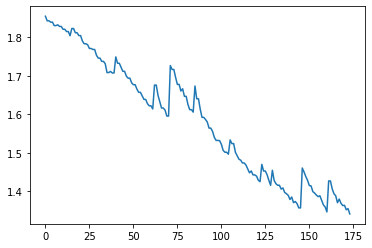

(140, 1)

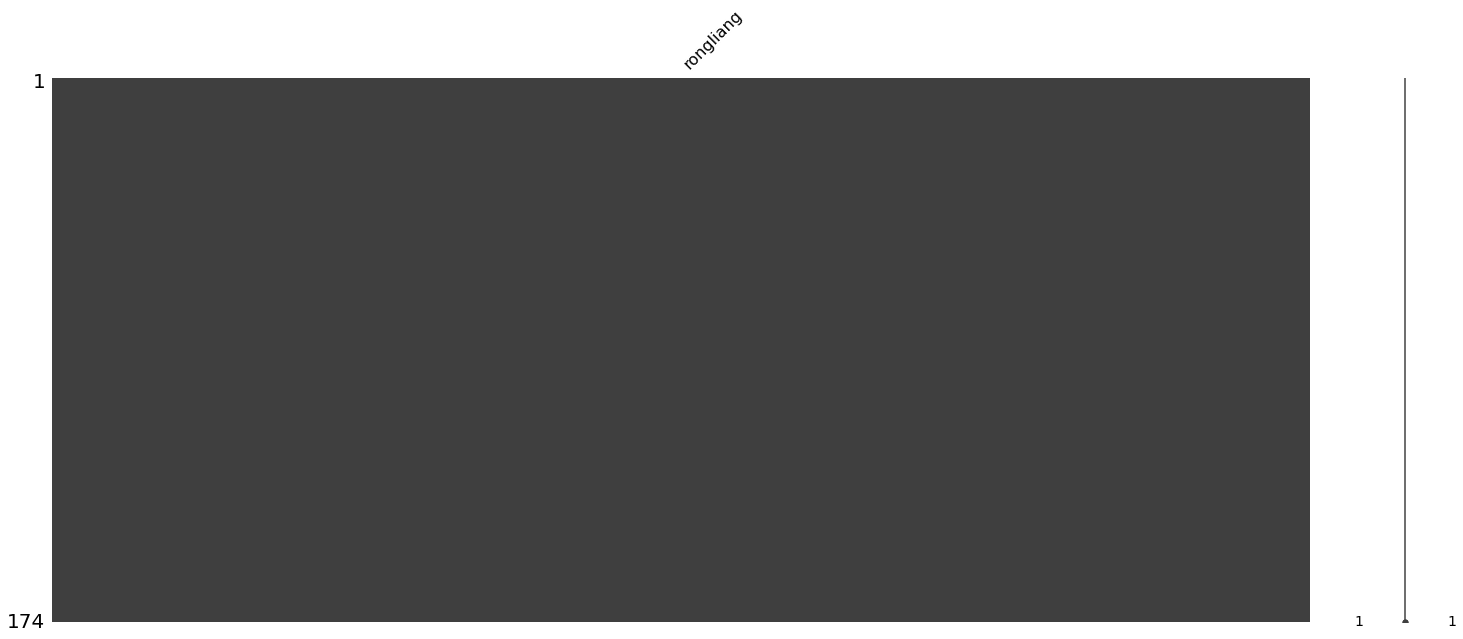

In [2]:
#df = pd.read_csv("B18rongliang.csv", index_col='日期')
df=pd.read_excel("./汇总/IMF1到RES/B07.xls")
print(df.head(6))   #输出前六行的内容
plt.plot(df)
plt.show()

msno.matrix(df)

data = df.sort_index(ascending=True, axis=0)
##只使用股票的收盘价来进行拟合和预测
#dataset=data[['rongliang']].values
dataset=data.values

data.head()
data.shape
dataset.shape

                                                                                    #
#取80%的数据作为训练集
training_data_len=math.ceil(len(dataset)*.8)
train_data=dataset[0:training_data_len,:]
#取剩下的数据作为测试集
#在做预测时，余下的数据的第一个数据，需要前60*200轮的数据来预测，因此这倒溯了60*200天
test_data = dataset[training_data_len-60: , : ]
                                                                                    #

scaler = MinMaxScaler(feature_range=(0,1))
scaled_train = scaler.fit_transform(train_data)
scaled_test = scaler.fit_transform(test_data)
scaled_train
scaled_test.shape
scaled_train.shape

训练集、测试集的重构

In [3]:
#训练集的重构
#1 分离x和y
x_train=[]
y_train=[]
                                                                        #
#for i in range(60,len(scaled_train)-10):
#    x_train.append(scaled_train[i-60:i,0])
#    y_train.append(scaled_train[i+10,0])
for i in range(60,len(scaled_train)):
    x_train.append(scaled_train[i-60:i,0])
    y_train.append(scaled_train[i,0])
                                                                        #
#2 将list类型数据转变成array数据
x_train,y_train=np.array(x_train),np.array(y_train)

#3 将二维数据变成三维数据
x_train=np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))

x_train.shape

#测试集的重构
#1 分离x和y
x_test = []
                                                                        #
#y_test = dataset[training_data_len+10: , : ] 
#for i in range(60,len(scaled_test)-10):
#    x_test.append(scaled_test[i-60:i,0])
y_test = dataset[training_data_len: , : ] 
for i in range(60,len(scaled_test)):
    x_test.append(scaled_test[i-60:i,0])
                                                                        #
#2 将list类型数据转变成array数据
x_test = np.array(x_test)
#3 将二维数据变成三维数据
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

x_test.shape

model = tf.keras.models.Sequential()

构建模型

In [5]:
#载入模型
model = load_model('model.h5')

#拟合模型
model.fit(x_train, y_train, batch_size=25, epochs=60)

Epoch 1/60
4/4 [==============================] - 5s 24ms/step - loss: 0.0046
Epoch 2/60
4/4 [==============================] - 0s 26ms/step - loss: 0.0058
Epoch 3/60
4/4 [==============================] - 0s 28ms/step - loss: 0.0058
Epoch 4/60
4/4 [==============================] - 0s 23ms/step - loss: 0.0058
Epoch 5/60
4/4 [==============================] - 0s 23ms/step - loss: 0.0053
Epoch 6/60
4/4 [==============================] - 0s 25ms/step - loss: 0.0067
Epoch 7/60
4/4 [==============================] - 0s 29ms/step - loss: 0.0061
Epoch 8/60
4/4 [==============================] - 0s 26ms/step - loss: 0.0083
Epoch 9/60
4/4 [==============================] - 0s 26ms/step - loss: 0.0080
Epoch 10/60
4/4 [==============================] - 0s 28ms/step - loss: 0.0075
Epoch 11/60
4/4 [==============================] - 0s 26ms/step - loss: 0.0079
Epoch 12/60
4/4 [==============================] - 0s 26ms/step - loss: 0.0056
Epoch 13/60
4/4 [==============================] - 0s 26ms/st

保存模型内容（重点是保存参数）

In [ ]:
model.save('model.h5')  #HDFS文件，pip install h5py,直接保存整个网络的参数和结构


开始预测

In [6]:
#预测
predictions = model.predict(x_test) 
#还原 特征缩放
predictions = scaler.inverse_transform(predictions)

2/2 [==============================] - 1s 5ms/step


计算AE、MAE、RMSE

In [7]:
predictions_fail = 0
actual_fail = 0
for i in range(len(predictions)):
    if predictions[i][0] <=1.45:
        predictions_fail = i+1+len(dataset)-len(predictions)
        break
for i in range(len(dataset)):
    if dataset[i][0] <=1.45:
        actual_fail= i+1
        break
  
ae = predictions_fail-actual_fail
mae = np.mean(np.abs(y_test - predictions))*100
rmse = np.sqrt(np.mean((y_test - predictions) ** 2))*100
print('预测寿命为',predictions_fail,'实际寿命为',actual_fail,'AE=',ae,'MAE=',mae,'%','RMSE=',rmse,'%')
#predictions=predictions.tolist()
#pre=[]
#for i in len(predictions):
#Spredictions=pd.DataFrame(predictions)
#print(predictions)
#train = data[:training_data_len]
#valid = data[training_data_len:]
#type(valid)
#type(train)

[[1.400722 ]
 [1.396227 ]
 [1.3913729]
 [1.3869475]
 [1.3826826]
 [1.3781939]
 [1.3738791]
 [1.3774031]
 [1.3839227]
 [1.3905529]
 [1.395838 ]
 [1.3987926]
 [1.400145 ]
 [1.39933  ]
 [1.3971707]
 [1.3940568]
 [1.390403 ]
 [1.386935 ]
 [1.3829669]
 [1.3782768]
 [1.373238 ]
 [1.3684446]
 [1.369027 ]
 [1.3723519]
 [1.3753337]
 [1.3769463]
 [1.3772898]
 [1.3756285]
 [1.3737545]
 [1.3711194]
 [1.3679047]
 [1.3647171]
 [1.3614905]
 [1.3585305]]


作图

rongliang    0.022215
dtype: float64
rongliang    0.03031
dtype: float64
     rongliang  Predictions
140   1.384901     1.400722
141   1.370325     1.396227
142   1.373346     1.391373
143   1.367949     1.386948
144   1.356714     1.382683
145   1.356714     1.378194
146   1.460431     1.373879
147   1.450100     1.377403
148   1.438141     1.383923
149   1.428368     1.390553
150   1.414787     1.395838
151   1.413889     1.398793
152   1.398933     1.400145
153   1.395332     1.399330
154   1.390046     1.397171
155   1.386027     1.394057
156   1.388215     1.390403
157   1.376183     1.386935
158   1.364717     1.382967
159   1.358985     1.378277
160   1.346231     1.373238
161   1.426843     1.368445
162   1.426843     1.369027
163   1.406448     1.372352
164   1.393491     1.375334
165   1.388249     1.376946
166   1.370188     1.377290
167   1.379695     1.375628
168   1.368659     1.373755
169   1.362737     1.371119
170   1.363405     1.367905
171   1.351865     1.364717
172

C:\Users\parkour\AppData\Local\Temp/ipykernel_102720/2863003791.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


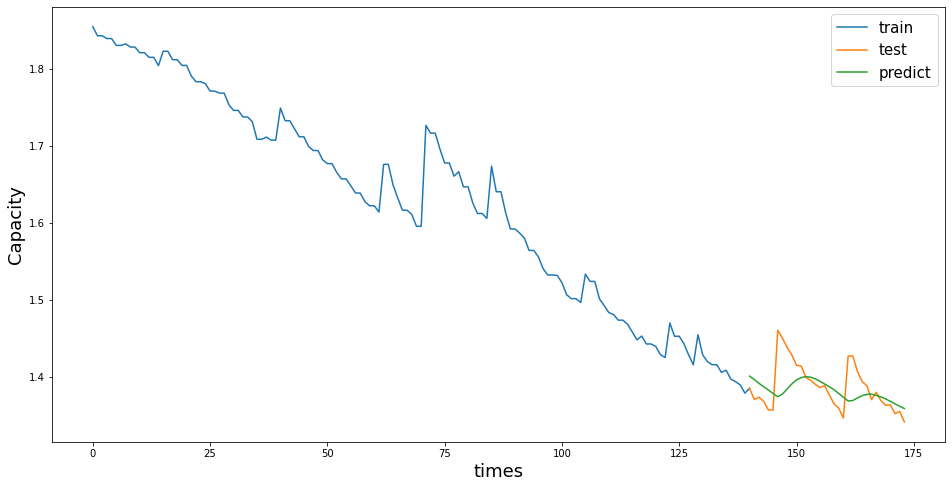

([], [])

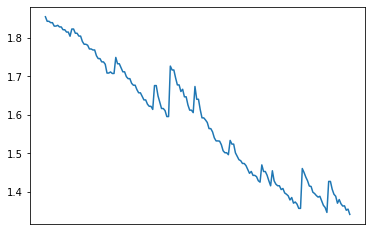

In [8]:
#创建用来画图的dataframe
train = data[:training_data_len+1]    #为了让输出的曲线相连，所以+1
valid = data[training_data_len:]
mae = np.sum(np.absolute(valid - predictions)) / len(valid)
#mse = np.mean(np.power((valid - predictions),2))
rmse = np.sqrt(np.mean(np.power((valid - predictions),2)))
print(mae)
print(rmse)

#predictions.head()    #取数据的前n行数据，默认是5行

#给valid添加新的一列，把预测值predictions赋值给新的一列
#valid['Predictions'] = predictions.values
valid['Predictions'] = predictions
print(valid)
#开始作图
#图像大小
plt.figure(figsize=(16,8))
#x轴
plt.xlabel('times', fontsize=18)
#y轴
plt.ylabel('Capacity', fontsize=18)
#画训练集的折线图
#plt.plot(train['收盘'])
plt.plot(train)
#分别画出真实值和预测值的折线图
#plt.plot(valid[['收盘', 'Predictions']])
plt.plot(valid[['rongliang', 'Predictions']])
#画出阈值线
plt.axhline(y=1.45,linestyle='--')
plt.plot(actual_fail-1,1.45,marker='*',markersize=5)
plt.plot(predictions_fail-1,1.45,marker='o',markersize=5)
#展示图例
plt.legend(['train', 'test', 'predict','threshold','actual RUL','predicted RUL'],fontsize=15)
plt.show()

plt.figure()
#plt.plot(data["收盘"])
plt.plot(data)
plt.xticks([])